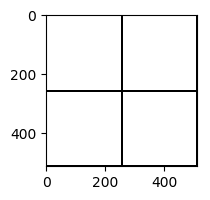

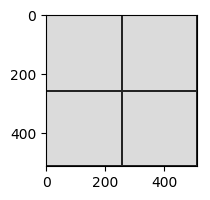

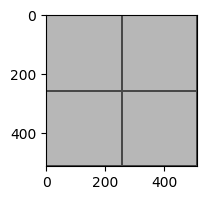

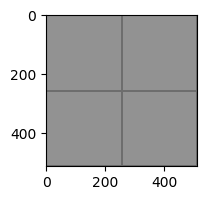

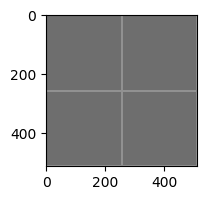

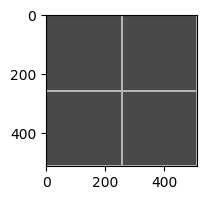

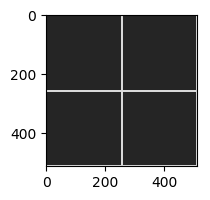

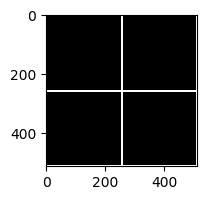

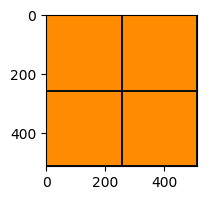

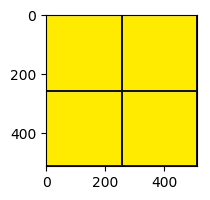

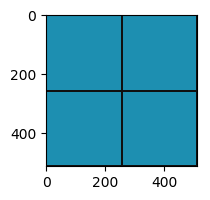

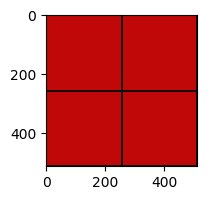

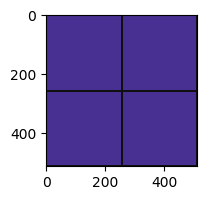

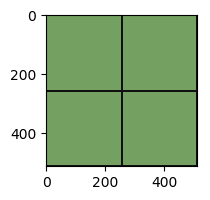

In [93]:
from meshmaker.plt import plot
from PIL import Image
import os

def make_texture(w, h, edgecolor, facecolor, ew=4):
    img = Image.new('RGBA', [w, h], 255)
    data = img.load()
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            xedge = x - ew < 0 or x + ew > w - 1
            yedge = y - ew < 0 or y + ew > h - 1
            xedge = xedge or abs(x - w // 2) < ew
            yedge = yedge or abs(y - h // 2) < ew
            if xedge or yedge:
                r, g, b = edgecolor
            else:
                r, g, b = facecolor
            data[x, y] = (r, g, b, 255)
            #    int(255 * round(r, 1)),
            #    int(255 * round(g, 1)),
            #    int(255 * round(b, 1)),
            #    255)
    return img

def make_generic_textures(prefix='./resources/textures/generics/generic', w=512, h=512):
    os.makedirs(os.path.dirname(prefix), exist_ok=True)
    pairs = []
    n = 8
    
    # grey pairs
    for i in np.linspace(0, 255, n).astype(int):
        j = 255 - i
        pairs.append(((i, i, i), (j, j, j)))
    
    pairs.append(((16, 16, 16), (255, 140, 0)))
    pairs.append(((16, 16, 16), (255, 235, 0)))
    pairs.append(((16, 16, 16), (29, 143, 177)))
    pairs.append(((16, 16, 16), (192, 8, 8)))
    pairs.append(((16, 16, 16), (72, 48, 147)))
    pairs.append(((16, 16, 16), (116, 161, 97)))
    
    # some colors
    #for i in np.linspace(0, 255, n).astype(int):
    #    j = 255 - i
    #    pairs.append(((i, i, i), (j //2, j // 2, j // 2)))
    
    for i, (ec, fc) in enumerate(pairs):    
        path = prefix + f'_{i}.png'
        img = make_texture(w, h, ec, fc)
        img.save(path)
        tex = Image.open(path)
        f, ax = plot(figsize=(2, 2))
        ax.imshow(tex)

make_generic_textures(w=512, h=512)

In [91]:
!ls ./resources/textures/generics/

generic_0.png  generic_2.png  generic_4.png  generic_6.png  generic_8.png
generic_1.png  generic_3.png  generic_5.png  generic_7.png  generic_9.png


In [ ]:
import pyximport; pyximport.install(reload_support=True, language_level=3)
import Cython.Compiler.Options
Cython.Compiler.Options.annotate = True
from meshmaker.v3 import vec3 as v3
from meshmaker.vec3 import vec3

In [3]:
%load_ext Cython

In [21]:
%%cython -a

cdef class vec3:
    
    cdef public float x
    cdef public float y
    cdef public float z
    
    def __cinit__(self, float x, float y, float z):
        self.x = x
        self.y = y
        self.z = z
        
    def __add__(self, o):
        return vec3(self.x + o.x, self.y + o.y, self.z + o.z)
            
    def __add__(self, o):
        return vec3(self.x + o.x, self.y + o.y, self.z + o.z)


In [10]:
a = vec3(1, 2, 3)

In [11]:
a.x, a.y, a.z

(1.0, 2.0, 3.0)

In [16]:
from meshmaker.vec3 import vec3
from pyrr import vector3

In [22]:
def test():
    for a in range(1000):
        b = vec3(1, 2, 3)
    
%timeit test()

151 µs ± 2.72 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
def test():
    for a in range(1000):
        b = vector3.create(1, 2, 3)

%timeit test()

1.58 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
import vectormath as vmath

def test():
    vector3 = vmath.Vector3
    for a in range(1000):
        b = vector3(1, 2, 3)

%timeit test()

20.6 ms ± 67 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1]:
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
import numpy as np


class mat44:
    
    @classmethod
    def I(cls):
        return cls(1, 0, 0, 0,
                   0, 1, 0, 0,
                   0, 0, 1, 0,
                   0, 0, 0, 1)
    
    @classmethod
    def tform(cls, t=None, q=None, s=None):
        if t is None:
            m14 = m24 = m34 = 0
        else:
            m14, m24, m34 = t.x, t.y, t.z
        if q is None:
            m11 = m22 = m33 = 1
            m12 = m13 = m23 = m21 = m31 = m32 = 0
        else:
            v = vec3(q.x, q.y, q.z).nrm()
            a = 2 * np.arccos(q.w)
            cosa, sina = np.cos(a), np.sin(a)
            m11 = v.x * v.x * (1 - cosa) + cosa
            m12 = v.y * v.x * (1 - cosa) - v.z * sina
            m13 = v.z * v.x * (1 - cosa) + v.y * sina
            m21 = v.x * v.y * (1 - cosa) + v.z * sina
            m22 = v.y * v.y * (1 - cosa) + cosa
            m23 = v.z * v.y * (1 - cosa) - v.x * sina
            m31 = v.x * v.z * (1 - cosa) - v.y * sina
            m32 = v.y * v.z * (1 - cosa) + v.x * sina
            m33 = v.z * v.z * (1 - cosa) + cosa
        if s is not None:
            m11 *= s.x
            m22 *= s.y
            m33 *= s.z
        return cls(m11, m12, m13, m14,
                   m21, m22, m23, m24,
                   m31, m32, m33, m34,
                     0,   0,   0,   1)
    
    def __repr__(self):
        return f'{self.m11} {self.m12} {self.m13} {self.m14}\
               \n{self.m21} {self.m22} {self.m23} {self.m24}\
               \n{self.m31} {self.m32} {self.m33} {self.m34}\
               \n{self.m41} {self.m42} {self.m43} {self.m44}'
    
    def __init__(self,
                 m11, m12, m13, m14,
                 m21, m22, m23, m24,
                 m31, m32, m33, m34,
                 m41, m42, m43, m44):
        self.m11, self.m12, self.m13, self.m14 = m11, m12, m13, m14
        self.m21, self.m22, self.m23, self.m24 = m21, m22, m23, m24
        self.m31, self.m32, self.m33, self.m34 = m31, m32, m33, m34
        self.m41, self.m42, self.m43, self.m44 = m41, m42, m43, m44
        
    def __mul__(self, o):
        if isinstance(o, vec3):
            return vec3(
                self.m11 * o.x + self.m12 * o.y + self.m13 * o.z + self.m14,
                self.m21 * o.x + self.m22 * o.y + self.m23 * o.z + self.m24,
                self.m31 * o.x + self.m32 * o.y + self.m33 * o.z + self.m34)
        elif isinstance(o, mat44):        
            return mat44(
                self.m11 * o.m11 + self.m12 * o.m21 + self.m13 * o.m31 + self.m14 * o.m41,
                self.m11 * o.m12 + self.m12 * o.m22 + self.m13 * o.m32 + self.m14 * o.m42,
                self.m11 * o.m13 + self.m12 * o.m23 + self.m13 * o.m33 + self.m14 * o.m43,
                self.m11 * o.m14 + self.m12 * o.m24 + self.m13 * o.m34 + self.m14 * o.m44,
                self.m21 * o.m11 + self.m22 * o.m21 + self.m23 * o.m31 + self.m24 * o.m41,
                self.m21 * o.m12 + self.m22 * o.m22 + self.m23 * o.m32 + self.m24 * o.m42,
                self.m21 * o.m13 + self.m22 * o.m23 + self.m23 * o.m33 + self.m24 * o.m43,
                self.m21 * o.m14 + self.m22 * o.m24 + self.m23 * o.m34 + self.m24 * o.m44,
                self.m31 * o.m11 + self.m32 * o.m21 + self.m33 * o.m31 + self.m34 * o.m41,
                self.m31 * o.m12 + self.m32 * o.m22 + self.m33 * o.m32 + self.m34 * o.m42,
                self.m31 * o.m13 + self.m32 * o.m23 + self.m33 * o.m33 + self.m34 * o.m43,
                self.m31 * o.m14 + self.m32 * o.m24 + self.m33 * o.m34 + self.m34 * o.m44,
                self.m41 * o.m11 + self.m42 * o.m21 + self.m43 * o.m31 + self.m44 * o.m41,
                self.m41 * o.m12 + self.m42 * o.m22 + self.m43 * o.m32 + self.m44 * o.m42,
                self.m41 * o.m13 + self.m42 * o.m23 + self.m43 * o.m33 + self.m44 * o.m43,
                self.m41 * o.m14 + self.m42 * o.m24 + self.m43 * o.m34 + self.m44 * o.m44)
        else:
            raise NotImplementedError


a = mat44.I()
print(a)
print()

d = mat44.tform(q=quat.av(np.pi/2, vec3.Z()))
print(d)
print(d * vec3.U())
print()

b = mat44.tform(t=vec3(2,3,4), q=quat.av(np.pi/4, vec3.Z()))
print(b)
print(b * vec3.U())
print()

c = mat44.tform(s=vec3(2,3,4))
print(c)
print(c * vec3.U())
print()

print(b * b * c * vec3.U())
print()

#print(m(vec3(1, 1, 1)))

1 0 0 0               
0 1 0 0               
0 0 1 0               
0 0 0 1

6.123233995736766e-17 -1.0 0.0 0               
1.0 6.123233995736766e-17 0.0 0               
0.0 0.0 1.0 0               
0 0 0 1
vec3(-1.0000, 1.0000, 1.0000)

0.7071067811865475 -0.7071067811865476 0.0 2               
0.7071067811865476 0.7071067811865475 0.0 3               
0.0 0.0 1.0 4               
0 0 0 1
vec3(2.0000, 4.4142, 5.0000)

2 0 0 0               
0 3 0 0               
0 0 4 0               
0 0 0 1
vec3(2.0000, 3.0000, 4.0000)

vec3(-1.7071, 8.5355, 12.0000)



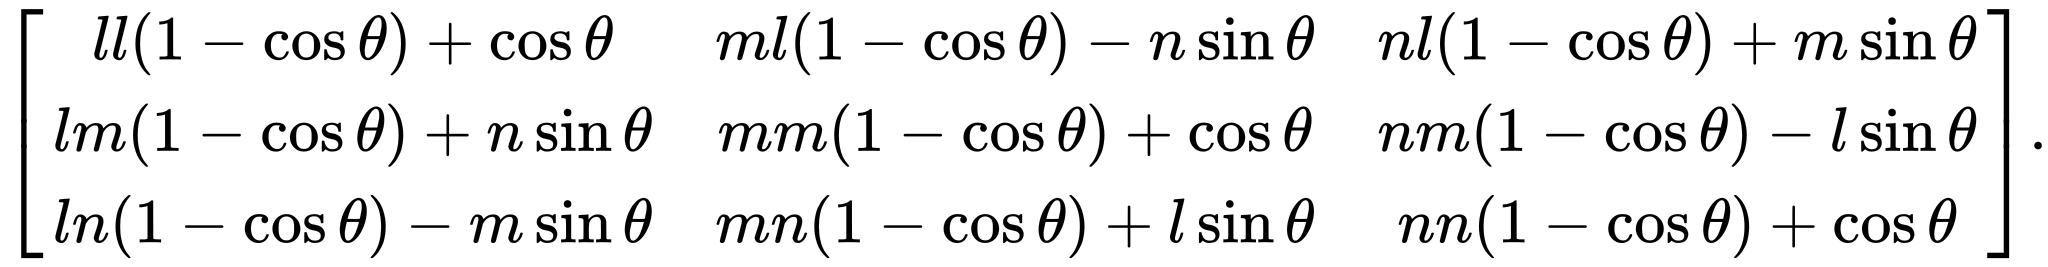

In [62]:
from IPython.display import SVG, display
display(SVG(filename='./resources/literature/0d1e67592644b14a3a6ba854eff849a852ee2c20.svg'))

In [69]:
from meshmaker.quat import quat
import numpy as np

q = quat.av(np.pi / 3, vec3.X())
v = vec3(q.x, q.y, q.z).nrm()
a = 2 * np.arccos(q.w)
c, s = np.cos(a), np.sin(a)
m11 = v.x * v.x * (1 - c) + c
m12 = v.y * v.x * (1 - c) - v.z * s
m13 = v.z * v.x * (1 - c) + v.y * s
m21 = v.x * v.y * (1 - c) + v.z * s
m22 = v.y * v.y * (1 - c) + c
m23 = v.z * v.y * (1 - c) - v.x * s
m31 = v.x * v.z * (1 - c) - v.y * s
m32 = v.y * v.z * (1 - c) + v.x * s
m33 = v.z * v.z * (1 - c) + c

print(a * 180 / np.pi, v)
print()
print(m11, m12, m13)
print(m21, m22, m23)
print(m31, m32, m33)


59.999999999999986 vec3(1.0000, 0.0000, 0.0000)

1.0 0.0 0.0
0.0 0.5000000000000003 -0.8660254037844385
0.0 0.8660254037844385 0.5000000000000003


In [5]:
#from pyrr import Matrix44

class tform:
    
    def world(self):
        if self.parent is None:
            base = mat44.I()
        else:
            base = self.parent.world()
        return base * self.transform
    
    def transform(self, vs):
        return [self.transformation * v for v in vs]
    
    def __init__(self, t=None, r=None, s=None,
                 parent=None, children=None, **kws):
        super().__init__(**kws)
        self.transformation = mat44.tform(t, r, s)

        self.parent = parent
        if parent:
            parent.add(self)
        self.children = []
        if children is not None:
            for child in children:
                self.add(child)
    
    def add(self, child):
        child.parent = self
        if not child in self.children:
            self.children.append(child)


In [6]:
tf1 = tform(vec3(3, 2, 4), None, None)
tf2 = tform(vec3(-3, -2, -4), None, vec3(-1, 2, -1), parent=tf1)

print(tf2.m)
print()
print(tf2.world())
print()
print(tf2(vec3.U(), vec3.U() * 10))

AttributeError: 'tform' object has no attribute 'm'

In [8]:
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat

In [9]:
vs = [vec3.U() for i in range(1000)]

def test():
    tf1 = tform(vec3(3, 2, 4), quat.av(np.pi / 2, vec3.Z()), None)
    tf2 = tform(vec3(-3, -2, -4), None, vec3(-1, 2, -1), parent=tf1)
    r = tf2.transform(vs)
    return r
    
def test2():
    tf1 = TForm(t=vec3(3, 2, 4), q=quat.av(np.pi / 2, vec3.Z()))
    tf2 = TForm(t=vec3(-3, -2, -4), s=vec3(-1, 2, -1), parent=tf1)
    r = tf2.transform(vs)
    return r

%timeit test()
%timeit test2()

1.63 ms ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.63 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
assert test() == test2()

AssertionError: 